In [1]:
import pandas as pd
import numpy as np
from abc import ABC
from typing import Callable
from sklearn.model_selection import train_test_split
import math as ma
import random
import csv
from collections import Counter
import matplotlib.pyplot as plt

### Métricas de erro

In [2]:
class EvaluationErrorMetrics:
    
    def rmse(y_real: np.ndarray, y_predicted: np.ndarray) -> float:
        diff = (y_real - y_predicted) ** 2
        result = np.sqrt(diff.mean())
        return result
    
    def mae(y_real: np.ndarray, y_predicted: np.ndarray) -> float:
        diff = (y_real - y_predicted)
        result = np.abs(diff.mean())
        return result
    
    def mre(y_real: np.ndarray, y_predicted: np.ndarray) -> float:
        diff = (y_real - y_predicted)
        result = np.abs(diff.mean())
        return result 

### Métricas de avaliação

In [3]:
class ClassificationMetrics:
    
    def accuracy(y_real: np.ndarray, y_predicted: np.ndarray) -> float:
        result = ((y_real == y_predicted).sum() / y_real.shape[0])
        return result 
    
    def precision(y_real: np.ndarray, y_predicted: np.ndarray) -> float:
        real = y_real.astype(bool)
        pred = y_predicted.astype(bool)
    
        T = real == 1
        F = ~T

        TP = pred[T].sum()
        FP = (~pred[F]).sum()

        result = (TP / (TP + FP))
        return result
    
    def recall(y_real: np.ndarray, y_predicted: np.ndarray) -> float:
        real = y_real.astype(bool)
        pred = y_predicted.astype(bool)
        
        T = real == True
        TP = pred[T].sum()
        FN = (~pred[T]).sum()
        
        result = (TP / (TP + FN))
        return result
    
    def f1_score(y_real: np.ndarray, y_predicted: np.ndarray) -> float:
        rec = ClassificationMetrics.recall(y_real, y_predicted)
        prec = ClassificationMetrics.precision(y_real, y_predicted)
        
        result = (2 * (float(rec) * float(prec)) / (float(rec) + float(prec)))
        return result

### Normalização e transformação de dados

In [4]:
class NormalizationData:
    
      def z_score(arr: np.ndarray):
        mean = arr.mean()
        std = arr.std()
        out = (arr - mean) / std
        return out
    
class EncoderData:
    
    def encode(count, label):
        enco = np.zeros(count)
        enco[int(label)] = 1
        return enco
    
    def label_encoder(y): 
        count = int(y.max() + 1)
        return np.array([EncoderData.encode(count, label) for label in y])
    
    def label_decoder(y):
        return y.argmax(axis=1)

### Algoritmos Regressão Logística, Análise de Discriminante Gaussiano e Naive Bayes Gaussiano

In [5]:
class ParamsInicialize(ABC):
    initial_w_values: float
    seed: int
    ephocs: int
    alpha: float
    l2: float
    predictions: bool

    def __init__(self, alpha=0.001, ephocs=4000, initial_w_values=1, l2=0, predictions=False, seed=1234):
        self.l2 = l2
        self.seed = seed
        self.predictions = predictions
        self.initial_w_values = initial_w_values
        self.ephocs = ephocs
        self.alpha = alpha

        def fit_train(self, x: np.ndarray, y: np.ndarray, **nargs): pass
        
class LogisticRegression(ParamsInicialize):
    
    def GD(self):
        n, m = self.X_bias.shape
        n_class = self.Y.shape[1]
        w = np.zeros((m, n_class))
        pred = np.zeros((n, n_class))
        
        for _ in range(self.ephocs):
            for k in range(n_class):
                y_sum = np.exp(self.X_bias @ w).sum(axis=1)
                pred = np.exp(self.X_bias @ w[:,k])
                e = (self.Y[:,k] - pred / y_sum).reshape(-1, 1)
                w[:,k] = w[:,k] + self.alpha * (1 / n) * (e * self.X_bias).sum(axis=0)
                
        self.w = w
        
    
    def bias(self, X):
        n = X.shape[0]
        return np.c_[np.ones(n), X]
    
    def fit_train(self, X, y):
        self.X = X
        self.y = y
        self.X_norm = NormalizationData.z_score(X)
        self.X_bias = self.bias(self.X_norm)
        self.Y = EncoderData.label_encoder(y)
        self.GD()
        
    def predict(self, X):
        X_norm = NormalizationData.z_score(X)
        X_bias = self.bias(X_norm)
        Y = X_bias @ self.w
        return EncoderData.label_decoder(Y)
    
class GaussianDiscriminant():
    
    def fit_train(self, X, y):
        n = X.shape[0]
        self.X = X
        self.y = y
        self.covs = []
        self.means = []
        self.probs = []
        self.n_classes = int(y.max() + 1)
        data = np.c_[ X, y ]
        for k in range(self.n_classes):
            data_k = data[data[:,-1] == k]
            X_k = data_k[:,:-1]
            self.probs.append(data_k.shape[0] / n)
            self.covs.append(np.cov(X_k.T))
            self.means.append(X_k.mean(axis=0))
  
    def prediction(self, x):
        class_predictions = []
        for k in range(self.n_classes):
            cov_det = np.linalg.det(self.covs[k])
            cov_inv = np.linalg.inv(self.covs[k])
            prediction = np.log(self.probs[k]) - 0.5 * np.log(cov_det) - 0.5 * (x - self.means[k]).T @ cov_inv @ (x - self.means[k])
            class_predictions.append(prediction)
        return np.argmax(class_predictions)

    def predict(self, X):
        return np.apply_along_axis(self.prediction, 1, X)
    
class GaussianNaiveBayes():
    
    def fit_train(self, X, y):
        self.m = X.shape[1]
        n = X.shape[0]
        self.X = X
        self.y = y
        self.stds = []
        self.means = []
        self.probs = []
        self.n_classes = int(y.max() + 1)
        data = np.c_[ X, y ]
        for k in range(self.n_classes):
            data_k = data[data[:,-1] == k]
            X_k = data_k[:,:-1]
            self.probs.append(data_k.shape[0] / n)
            self.stds.append(X_k.std(axis=0))
            self.means.append(X_k.mean(axis=0))
  
    def prediction(self, x):
        class_predictions = []
        for k in range(self.n_classes):
            sum = 0
            for d in range(self.m):
                var = self.stds[k][d] ** 2
                sum += np.log(2 * np.pi * var) + (x[d] - self.means[k][d]) ** 2 / var
                prediction = np.log(self.probs[k]) - 0.5 * sum
                class_predictions.append(prediction)
        return np.argmax(class_predictions)

    def predict(self, X):
        return np.apply_along_axis(self.prediction, 1, X)

### Importação e separação de dados

In [6]:
df = pd.read_csv('data/breastcancer.csv', header=None)
df

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,0.0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,0.0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,0.0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,0.0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,0.0
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,0.0
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,0.0
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,0.0


In [7]:
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=40, stratify=y)

### Treinamento do modelos

#### Regressão Logística

In [9]:
lr = LogisticRegression(predictions=True)
lr.fit_train(X_train, y_train)
prediction = lr.predict(X_test)
accuracy = ClassificationMetrics.accuracy(y_test, prediction)
precision = ClassificationMetrics.precision(y_test, prediction)
recall = ClassificationMetrics.recall(y_test, prediction)
f1_score = ClassificationMetrics.f1_score(y_test, prediction)

In [10]:
print("------ Logistic Regression Metrics Results ------")
print("Accuracy Model: ", accuracy)
print("Precision Model: ", precision)
print("Recall Model: ", recall)
print("F1_score Model: ", f1_score)

------ Logistic Regression Metrics Results ------
Accuracy Model:  0.9824561403508771
Precision Model:  0.6369047619047619
Recall Model:  1.0
F1_score Model:  0.7781818181818182


#### Análise do Discriminante Gaussiano

In [11]:
gda = GaussianDiscriminant()
gda.fit_train(X_train, y_train)
prediction = gda.predict(X_test)
accuracy = ClassificationMetrics.accuracy(y_test, prediction)
precision = ClassificationMetrics.precision(y_test, prediction)
recall = ClassificationMetrics.recall(y_test, prediction)
f1_score = ClassificationMetrics.f1_score(y_test, prediction)

In [12]:
print("------ Gaussian Discriminant Metrics Results ------")
print("Accuracy Model: ", accuracy)
print("Precision Model: ", precision)
print("Recall Model: ", recall)
print("F1_score Model: ", f1_score)

------ Gaussian Discriminant Metrics Results ------
Accuracy Model:  0.9532163742690059
Precision Model:  0.6196319018404908
Recall Model:  0.9439252336448598
F1_score Model:  0.7481481481481482


#### Naive Bayes Gaussiano

In [13]:
gnb = GaussianNaiveBayes()
gnb.fit_train(X_train, y_train)
prediction = gnb.predict(X_test)
accuracy = ClassificationMetrics.accuracy(y_test, prediction)
precision = ClassificationMetrics.precision(y_test, prediction)
recall = ClassificationMetrics.recall(y_test, prediction)
f1_score = ClassificationMetrics.f1_score(y_test, prediction)

In [14]:
print("------ Gaussian Naive Bayes Metrics Results ------")
print("Accuracy Model: ", accuracy)
print("Precision Model: ", precision)
print("Recall Model: ", recall)
print("F1_score Model: ", f1_score)

------ Gaussian Naive Bayes Metrics Results ------
Accuracy Model:  0.06432748538011696
Precision Model:  0.9067796610169492
Recall Model:  1.0
F1_score Model:  0.9511111111111111


### Avaliação dos modelos com K folds

In [15]:
class Kfolds():
    
    def __init__(self, folds = 10):
        self.folds = folds
        
    def fold(self):
        
        np.random.shuffle(self.data)
        n = self.data.shape[0]
        self.n_folds = []
        folds_size = ma.ceil(n / self.folds)     
        for i in range(0, n, folds_size):
            end = i + folds_size
            end = n if end > n else end
            fold = self.data[i: end,:]
            self.n_folds.append(fold)
            
    def predict(self, index):
        folds = self.n_folds[:]
        
        test_fold = folds.pop(index)
        train_fold = np.vstack(folds)
        
        x_train = train_fold[:, :-1]
        y_train = train_fold[:, -1]
        x_test = test_fold[:, :-1]
        y_test = test_fold[:, -1]
        
        self.model.fit_train(x_train, y_train)
        pred = self.model.predict(x_test)
        
        return pred, y_test
    
    def folds_results_metrics(self):
        
        self.accuracies = []
        self.precisions = []
        self.recalls = []
        self.f1_score = []
        
        for i in range(self.folds):
            pred, y_test = self.predict(i)
            accuracy = ClassificationMetrics.accuracy(y_test, pred)
            precision = ClassificationMetrics.precision(y_test, pred)
            recall = ClassificationMetrics.recall(y_test, pred)
            f1_score = ClassificationMetrics.f1_score(y_test, pred)
            
            self.accuracies.append(accuracy)
            self.precisions.append(precision)
            self.recalls.append(recall)
            self.f1_score.append(f1_score)
            
        self.accurancy_mean = np.mean(self.accuracies)
        self.precision_mean = np.mean(self.precisions)
        self.recall_mean = np.mean(self.recalls)
        self.f1_score_mean = np.mean(self.f1_score)
        
        self.accurancy_std = np.std(self.accuracies)
        self.precision_std = np.std(self.precisions)
        self.recall_std = np.std(self.recalls)
        self.f1_score_std = np.std(self.f1_score)
        
    def fit_folds(self, model, x, y):
        self.data = np.c_[ x, y ]
        self.model = model
        self.fold()
        self.folds_results_metrics()

In [16]:
models = {
    'Análise do Discriminante Gaussiano': gda,
    'Regressão Logística': lr,
    'Naive Bayes Gaussiano': gnb
}
models_names = list(models.keys())

In [17]:
accuracies_means = []
precisions_means = []
f1_score_means = []
recalls_means = []

accuracies_stds = []
precisions_stds = []
f1_score_stds = []
recalls_stds = []

for model_name, model in models.items():
    kfolds = Kfolds()
    kfolds.fit_folds(model, X, y)

    accuracies_means.append(kfolds.accurancy_mean)
    precisions_means.append(kfolds.precision_mean)
    recalls_means.append(kfolds.recall_mean)
    f1_score_means.append(kfolds.f1_score_mean)

    accuracies_stds.append(kfolds.accurancy_std)
    precisions_stds.append(kfolds.precision_std)
    recalls_stds.append(kfolds.recall_std)
    f1_score_stds.append(kfolds.f1_score_std)

### Médias das métricas 

In [18]:
metrics = ["Acurácia", "Precisão", "Revocação", "F1-Score"]
gda_metrics_mean, rl_metrics_mean, gnb_metrics_mean = np.array([accuracies_means, precisions_means, recalls_means, f1_score_means]).T
gda_metrics_std, rl_metrics_std, gnb_metrics_std = np.array([accuracies_stds, precisions_stds, recalls_stds, f1_score_stds]).T

In [19]:
gda_metrics_mean

array([0.95429198, 0.6351651 , 0.96593499, 0.7646547 ])

### Visualização dos resultados das métricas por modelo

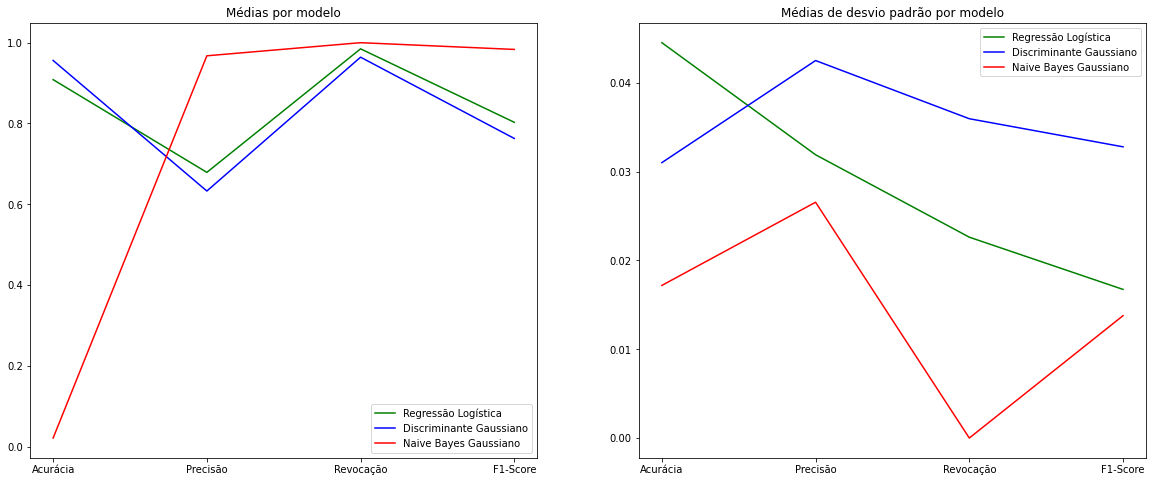

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8))

ax1.set_title("Médias por modelo")
ax1.plot(metrics, rl_metrics_mean, 'g', label="Regressão Logística")
ax1.plot(metrics, gda_metrics_mean, 'b', label="Discriminante Gaussiano")
ax1.plot(metrics, gnb_metrics_mean, 'r', label="Naive Bayes Gaussiano")
ax1.legend()

ax2.set_title("Médias de desvio padrão por modelo")
ax2.plot(metrics, rl_metrics_std, 'g', label="Regressão Logística")
ax2.plot(metrics, gda_metrics_std, 'b', label="Discriminante Gaussiano")
ax2.plot(metrics, gnb_metrics_std, 'r', label="Naive Bayes Gaussiano")
ax2.legend()